# Time Series Queries
## A sample of the retail_sales table

In [1]:
SELECT top 10 *
from dbo.us_retail_sales

(10 rows affected)

Total execution time: 00:00:00.010

sales_month,naics_code,kind_of_business,reason_for_null,sales
1992-01-01,441,Motor vehicle and parts dealers,NULL,29811
1992-01-01,4411,Automobile dealers,NULL,25800
1992-01-01,"4411, 4412",Automobile and other motor vehicle dealers,NULL,26788
1992-01-01,44111,New car dealers,NULL,24056
1992-01-01,44112,Used car dealers,NULL,1744
1992-01-01,4413,"Automotive parts, acc., and tire stores",NULL,3023
1992-01-01,442,Furniture and home furnishings stores,NULL,3846
1992-01-01,"442, 443","Furniture, home furn, electronics, and appliance stores",NULL,7503
1992-01-01,4421,Furniture stores,NULL,2392
1992-01-01,4422,Home furnishings stores,NULL,1454


## Trending the data
### Simple trend

In [5]:
-- Check the trend of total retail and food services sales in the US
select top 12
    sales_month,
    sales
from dbo.us_retail_sales
where kind_of_business = 'Retail and food services sales, total'
ORDER BY sales_month

(12 rows affected)

Total execution time: 00:00:00.054

sales_month,sales
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068
1992-06-01,168663
1992-07-01,169890
1992-08-01,170364
1992-09-01,164617
1992-10-01,173655


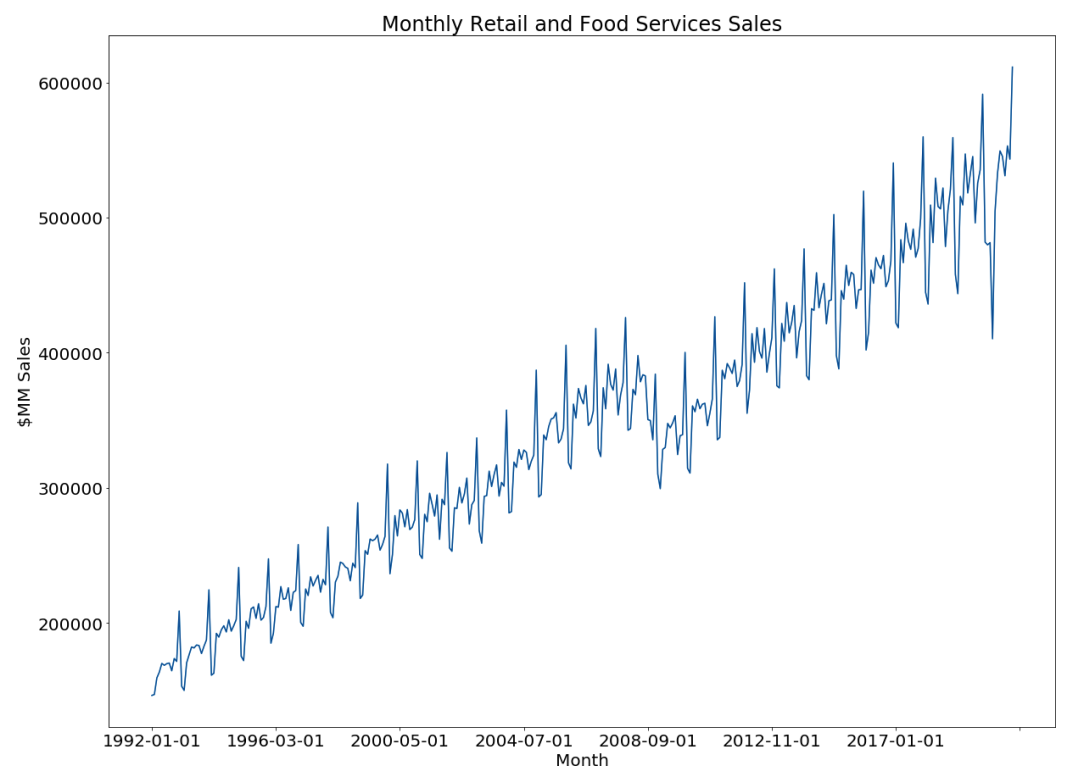

In [8]:
-- Aggregating at year level to remove noise
SELECT top 10
    YEAR(sales_month) as year,
    sum(sales) sales
from dbo.us_retail_sales
where kind_of_business = 'Retail and food services sales, total'
GROUP BY YEAR(sales_month)
ORDER BY 1

(10 rows affected)

Total execution time: 00:00:00.013

year,sales
1992,2014102
1993,2153095
1994,2330235
1995,2450628
1996,2603794
1997,2726131
1998,2852956
1999,3086990
2000,3287537
2001,3378906


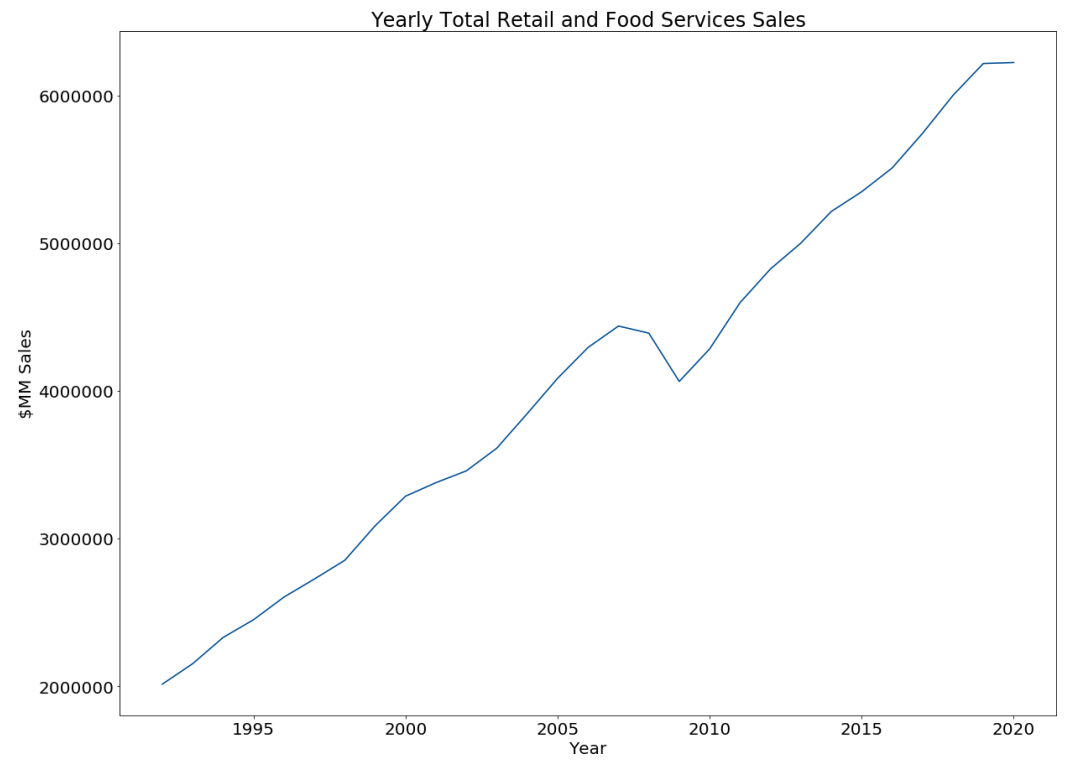

### Comparing Components

In [9]:
-- Trend of yearly retail sales for sporting goods stores; hobby, toy, and game stores; 
-- and book stores
SELECT top 9
    YEAR(sales_month) as year,
    kind_of_business,
    sum(sales) sales
from dbo.us_retail_sales
where kind_of_business in ('Book stores','Sporting goods stores','Hobby, toy, and game stores')
GROUP BY YEAR(sales_month), kind_of_business
ORDER BY 1, 2

(9 rows affected)

Total execution time: 00:00:00.017

year,kind_of_business,sales
1992,Book stores,8327
1992,"Hobby, toy, and game stores",11251
1992,Sporting goods stores,15583
1993,Book stores,9108
1993,"Hobby, toy, and game stores",11651
1993,Sporting goods stores,16791
1994,Book stores,10107
1994,"Hobby, toy, and game stores",12850
1994,Sporting goods stores,18825


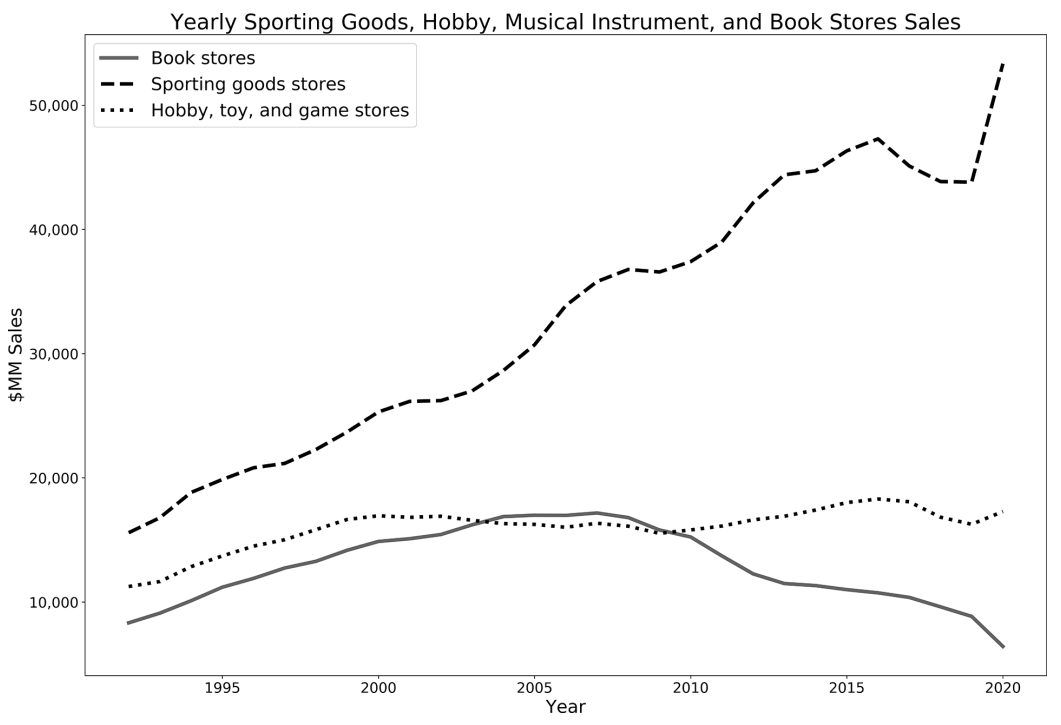

- Sales at sporting goods retailers started the highest among the three categories and grew much faster during the time period, and by 2020, those sales were substantially higher
- Sales at hobby, toy, and game stores were relatively flat over this time span   
- Sales at book stores grew until the mid-2000s and have been on the decline since then.

In [12]:
-- Monthly trend of sales at women’s and men’s clothing stores
SELECT top 12
    sales_month,
    kind_of_business,
    sales
from dbo.us_retail_sales
where kind_of_business in ('Men''s clothing stores' ,'Women''s clothing stores')
order by sales_month, kind_of_business

(12 rows affected)

Total execution time: 00:00:00.019

sales_month,kind_of_business,sales
1992-01-01,Men's clothing stores,701
1992-01-01,Women's clothing stores,1873
1992-02-01,Men's clothing stores,658
1992-02-01,Women's clothing stores,1991
1992-03-01,Men's clothing stores,731
1992-03-01,Women's clothing stores,2403
1992-04-01,Men's clothing stores,816
1992-04-01,Women's clothing stores,2665
1992-05-01,Men's clothing stores,856
1992-05-01,Women's clothing stores,2752


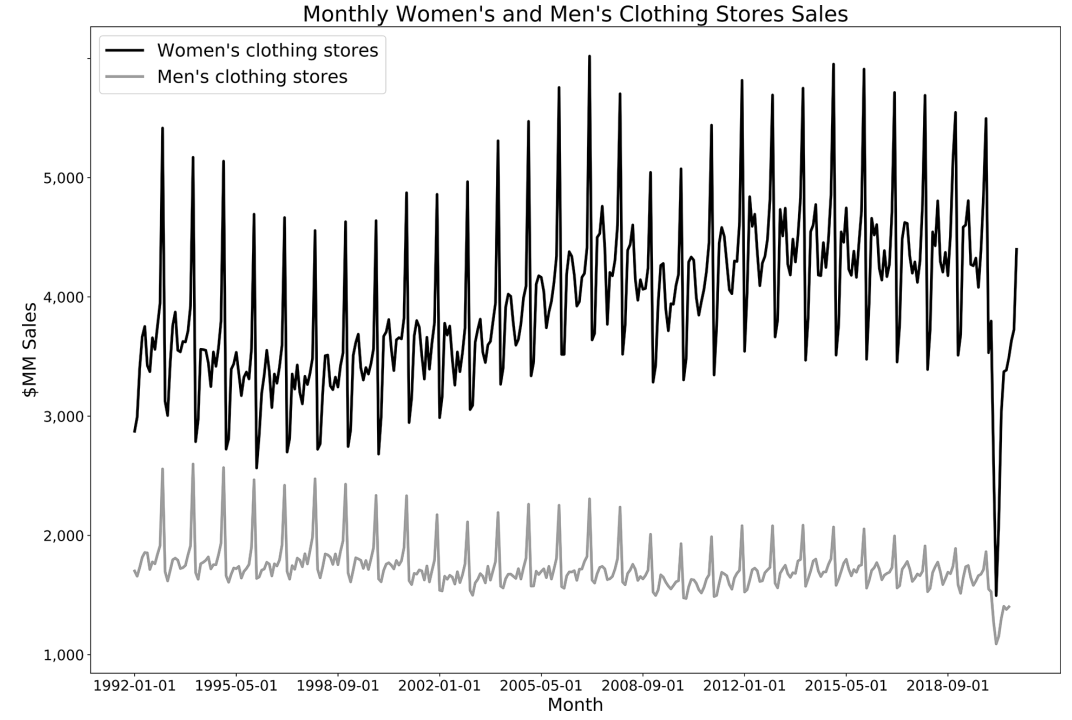

- Sales at women’s clothing retailers are much higher than those at men’s clothing retailers. 
- Both types of stores exhibit seasonality. 
- Both experienced significant drops in 2020 due to store closures and a reduction in shopping because of the COVID-19 pandemic.

In [15]:
-- Yearly trend of sales at women’s and men’s clothing stores
SELECT top 12
    YEAR(sales_month) AS year,
    kind_of_business,
    SUM(sales) as sales
FROM dbo.us_retail_sales
WHERE kind_of_business IN ('Men''s clothing stores' ,'Women''s clothing stores')
GROUP BY YEAR(sales_month), kind_of_business
ORDER BY 1, 2


(12 rows affected)

Total execution time: 00:00:00.065

year,kind_of_business,sales
1992,Men's clothing stores,10179
1992,Women's clothing stores,31815
1993,Men's clothing stores,9962
1993,Women's clothing stores,32350
1994,Men's clothing stores,10032
1994,Women's clothing stores,30585
1995,Men's clothing stores,9315
1995,Women's clothing stores,28696
1996,Men's clothing stores,9546
1996,Women's clothing stores,28238


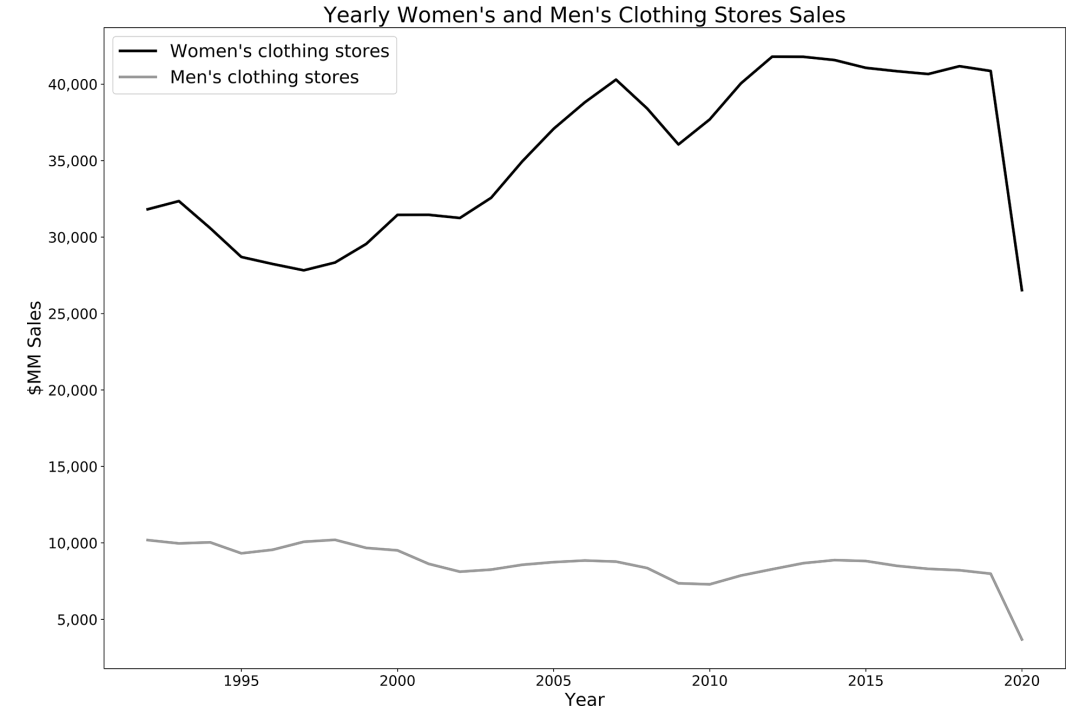

- The gap between men’s and women’s sales does not appear constant but rather was increasing    
- Women’s clothing sales in particular dipped during the global financial crisis of 2008–2009

In [23]:
-- Create a pivot table of  yearly sales between women's and men's stores and save as a view
CREATE VIEW yearly_sales_women_vs_men_clothing_stores
AS
SELECT * FROM
(   
    SELECT
        kind_of_business,
        sales,
        YEAR(sales_month) AS year
    FROM dbo.us_retail_sales
    WHERE kind_of_business IN ('Men''s clothing stores' ,'Women''s clothing stores')
        AND sales_month <= '2019-12-01' -- 2020 data was removed, since a few months had null values
) t
PIVOT (
    SUM(sales)
    FOR kind_of_business IN (
        [women's clothing stores],
        [Men's clothing stores]
    )
) AS pivot_table;
GO

-- Yearly difference between sales at women’s and men’s clothing stores
SELECT top 10
    year,
    [women's clothing stores] - [Men's clothing stores] as women_minus_men
FROM yearly_sales_women_vs_men_clothing_stores

Commands completed successfully.

(10 rows affected)

Total execution time: 00:00:00.205

year,women_minus_men
1992,21636
1993,22388
1994,20553
1995,19381
1996,18692
1997,17753
1998,18136
1999,19882
2000,21940
2001,22828


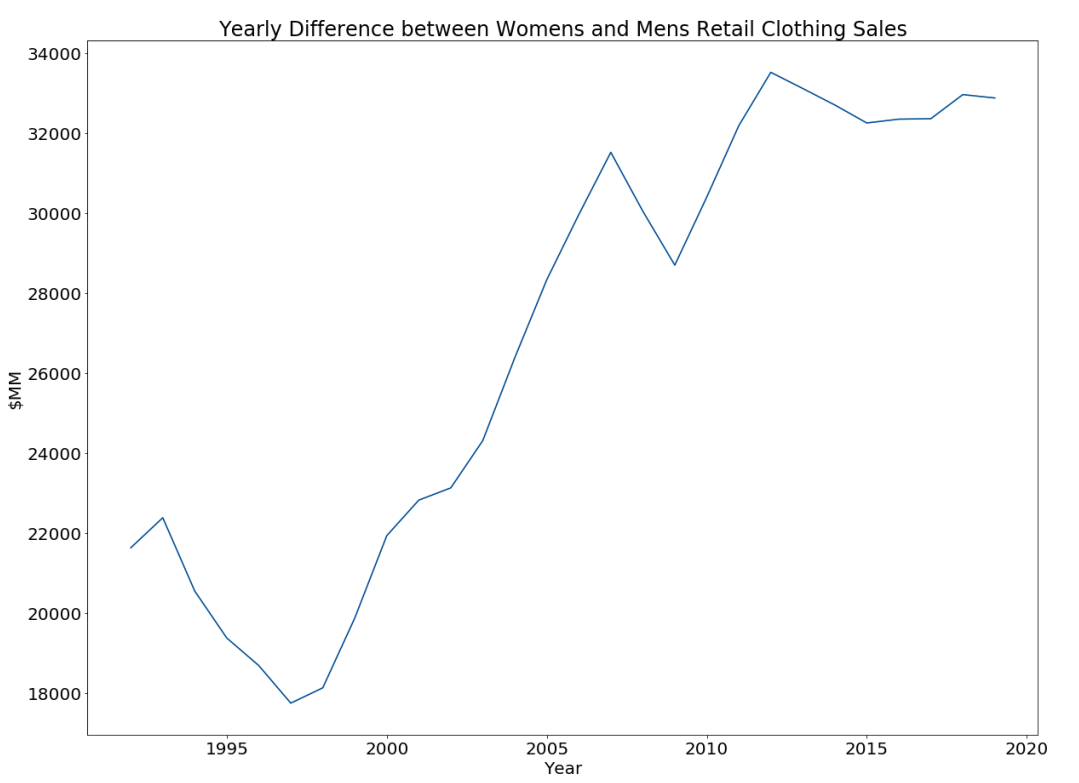

In [46]:
-- Yearly % difference of women’s to men’s clothing sales
SELECT top 10
    year,
    CAST(
        (CAST([women's clothing stores] AS decimal (10,3)) / [Men's clothing stores] -1)*100
        AS decimal(10,3)
        ) AS pct_diff
FROM yearly_sales_women_vs_men_clothing_stores

(10 rows affected)

Total execution time: 00:00:00.018

year,pct_diff
1992,212.555
1993,224.734
1994,204.874
1995,208.062
1996,195.810
1997,176.313
1998,177.874
1999,205.669
2000,230.777
2001,264.672


### Percent of Total Calculations

In [50]:
-- Men’s and women’s clothing store sales as % of monthly total
SELECT top 12
    sales_month,
    kind_of_business,
    sales,
    cast(sales as dec(10,3))*100 / sum(sales) 
        over (partition by sales_month) as pct_sales
FROM dbo.us_retail_sales
WHERE kind_of_business IN ('Men''s clothing stores' ,'Women''s clothing stores')

(12 rows affected)

Total execution time: 00:00:00.022

sales_month,kind_of_business,sales,pct_sales
1992-01-01,Men's clothing stores,701,27.23387723387723387723387
1992-01-01,Women's clothing stores,1873,72.76612276612276612276612
1992-02-01,Men's clothing stores,658,24.83956209890524726311815
1992-02-01,Women's clothing stores,1991,75.16043790109475273688184
1992-03-01,Men's clothing stores,731,23.32482450542437779195915
1992-03-01,Women's clothing stores,2403,76.67517549457562220804084
1992-04-01,Men's clothing stores,816,23.44153978741740879057742
1992-04-01,Women's clothing stores,2665,76.55846021258259120942257
1992-05-01,Men's clothing stores,856,23.72505543237250554323725
1992-05-01,Women's clothing stores,2752,76.27494456762749445676274


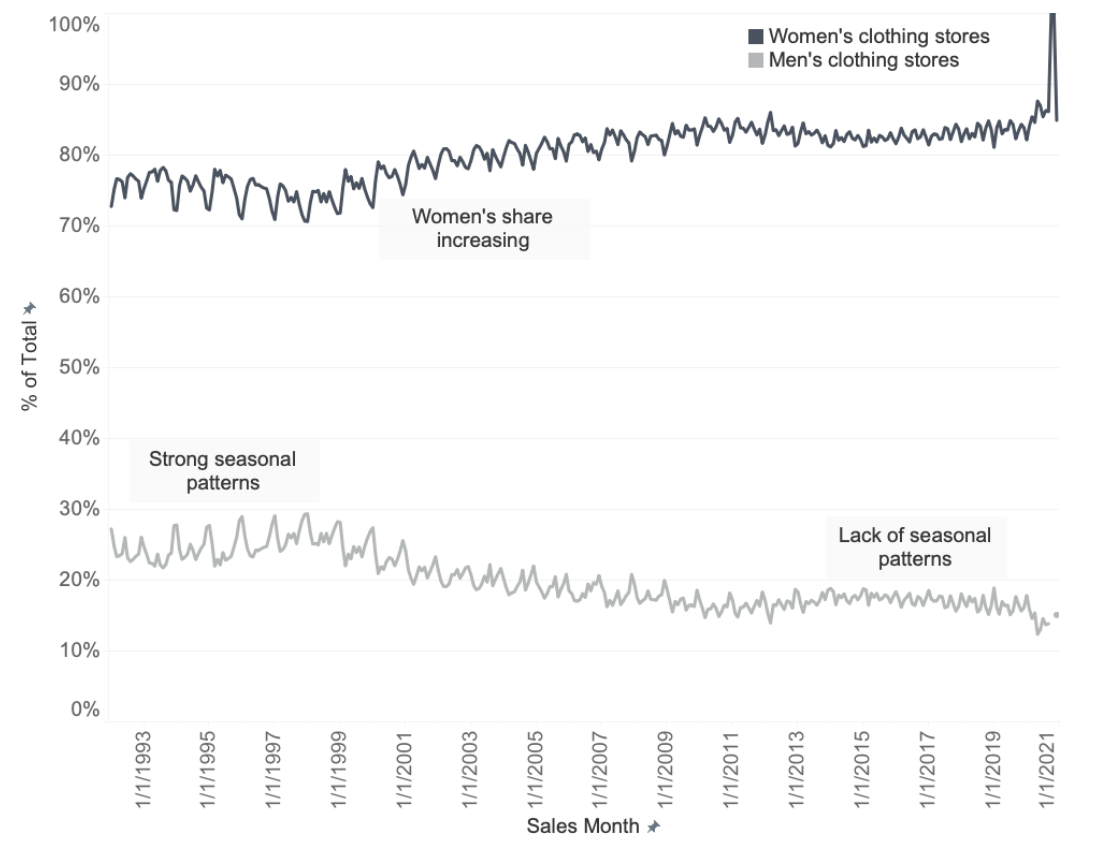

- Starting in the late 1990s, women’s clothing store sales became an increasing percentage of the total.
- Early in the series a seasonal pattern is evident

In [54]:
-- % of yearly sales for 2019 for women’s and men’s clothing sales
SELECT top 12
    sales_month,
    kind_of_business,
    sales,
    cast(sales as dec(10,3))*100 / sum(sales) over (partition by YEAR(sales_month), kind_of_business) as pct_sales
FROM dbo.us_retail_sales
WHERE kind_of_business IN ('Men''s clothing stores' ,'Women''s clothing stores')
    AND YEAR(sales_month) = 2019
ORDER BY 1, 2

(12 rows affected)

Total execution time: 00:00:00.030

sales_month,kind_of_business,sales,pct_sales
2019-01-01,Men's clothing stores,585,7.32990853276531762936975
2019-01-01,Women's clothing stores,2511,6.14522405227478524754656
2019-02-01,Men's clothing stores,514,6.44029570229294574614709
2019-02-01,Women's clothing stores,2680,6.55882137001052348204889
2019-03-01,Men's clothing stores,642,8.04410474877834857787244
2019-03-01,Women's clothing stores,3585,8.77364724309243532953182
2019-04-01,Men's clothing stores,737,9.23443177546673349204360
2019-04-01,Women's clothing stores,3604,8.82014634982012187660605
2019-05-01,Men's clothing stores,747,9.35972935722340558827214
2019-05-01,Women's clothing stores,3807,9.31695259538435182692543


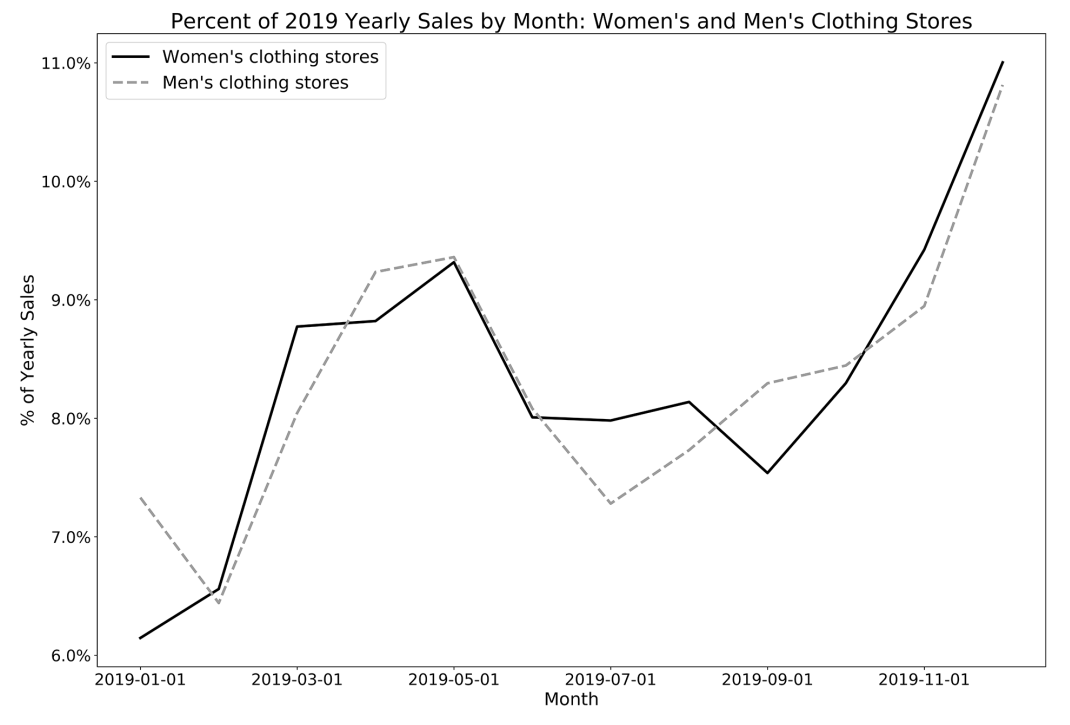

- Men’s stores had a greater percentage of their sales in January than did women’s stores
- Men’s stores had a summer dip in July, while the corresponding dip in women’s store sales wasn’t until September

### Indexing to See Percent Change over Time

In [59]:
-- Men’s and women’s clothing store sales, indexed to 1992 sales
SELECT top 10
    sales_year,
    kind_of_business,
    (CAST(sales as dec(10,3)) / 
        FIRST_VALUE(sales) OVER (partition by kind_of_business ORDER BY sales_year) - 1)*100 
        AS base_sales
FROM
(
    SELECT
    year(sales_month) sales_year,
    kind_of_business,
    sum(sales) sales
    from dbo.us_retail_sales
    where kind_of_business IN ('Women''s clothing stores', 'Men''s clothing stores')
        AND sales_month <= '2019-12-01'
    GROUP BY YEAR(sales_month), kind_of_business
) year_sales
ORDER BY 1, 2

(10 rows affected)

Total execution time: 00:00:00.018

sales_year,kind_of_business,base_sales
1992,Men's clothing stores,0.00000000000000000000000
1992,Women's clothing stores,0.00000000000000000000000
1993,Men's clothing stores,-2.13184006287454563316700
1993,Women's clothing stores,1.68159673110168159673100
1994,Men's clothing stores,-1.44414972001178897730700
1994,Women's clothing stores,-3.86610089580386610089600
1995,Men's clothing stores,-8.48806366047745358090200
1995,Women's clothing stores,-9.80355178374980355178400
1996,Men's clothing stores,-6.21868552903035661656400
1996,Women's clothing stores,-11.24312431243124312431300


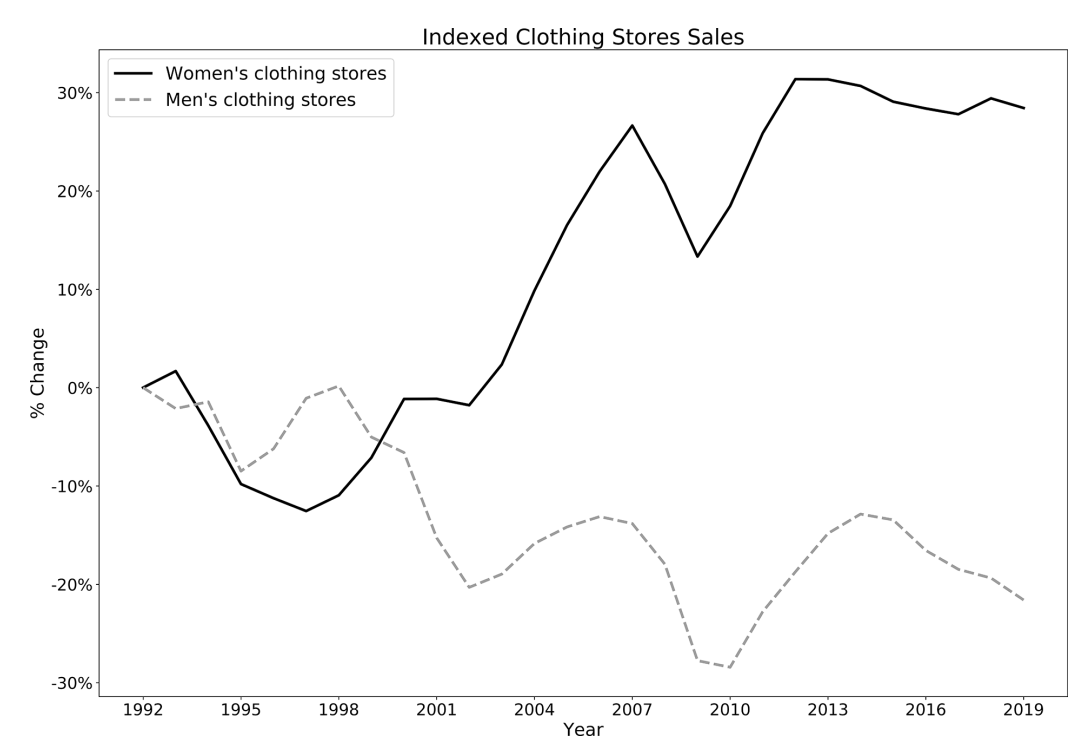

- After 1992 men's clothing sales dropped, then returned briefly to the same level in 1998, and have been declining ever since ( the data set is not adjusted for inflation).
- Sales at women’s clothing stores decreased from 1992 levels initially, but they returned to the 1992 level by 2003. They have increased since, with the exception of the drop during the financial crisis in 2009-2010

## Rolling Time Windows

In [61]:
-- 12-month moving average for women's clothing stores sales, using SELF-JOIN
SELECT TOP 12
    a.sales_month
    ,a.sales
    ,avg(CAST(b.sales AS dec(10,3))) as moving_avg
    ,count(b.sales) as records_count
FROM dbo.us_retail_sales a
JOIN dbo.us_retail_sales b on a.kind_of_business = b.kind_of_business 
 and b.sales_month between DATEADD(month, -11, a.sales_month) 
    and a.sales_month
 and b.kind_of_business = 'Women''s clothing stores'
WHERE a.kind_of_business = 'Women''s clothing stores'
and a.sales_month >= '1993-01-01'
GROUP BY a.sales_month, a.sales
ORDER BY 1

(12 rows affected)

Total execution time: 00:00:00.021

sales_month,sales,moving_avg,records_count
1993-01-01,2123,2672.083333,12
1993-02-01,2005,2673.250000,12
1993-03-01,2442,2676.500000,12
1993-04-01,2762,2684.583333,12
1993-05-01,2873,2694.666666,12
1993-06-01,2552,2705.333333,12
1993-07-01,2539,2719.166666,12
1993-08-01,2626,2716.583333,12
1993-09-01,2622,2721.750000,12
1993-10-01,2713,2718.250000,12


In [63]:
-- 12-month moving average, using window function
SELECT TOP 12
    sales_month
    ,sales
,avg(CAST(sales AS dec(10,3))) OVER (ORDER BY sales_month ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) as moving_avg
,COUNT(sales) OVER (ORDER BY sales_month ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) as count
FROM dbo.us_retail_sales
WHERE kind_of_business = 'Women''s clothing stores'
GROUP BY sales_month, sales
ORDER BY 1

(12 rows affected)

Total execution time: 00:00:00.155

sales_month,sales,moving_avg,count
1992-01-01,1873,1873.000000,1
1992-02-01,1991,1932.000000,2
1992-03-01,2403,2089.000000,3
1992-04-01,2665,2233.000000,4
1992-05-01,2752,2336.800000,5
1992-06-01,2424,2351.333333,6
1992-07-01,2373,2354.428571,7
1992-08-01,2657,2392.250000,8
1992-09-01,2560,2410.888888,9
1992-10-01,2755,2445.300000,10


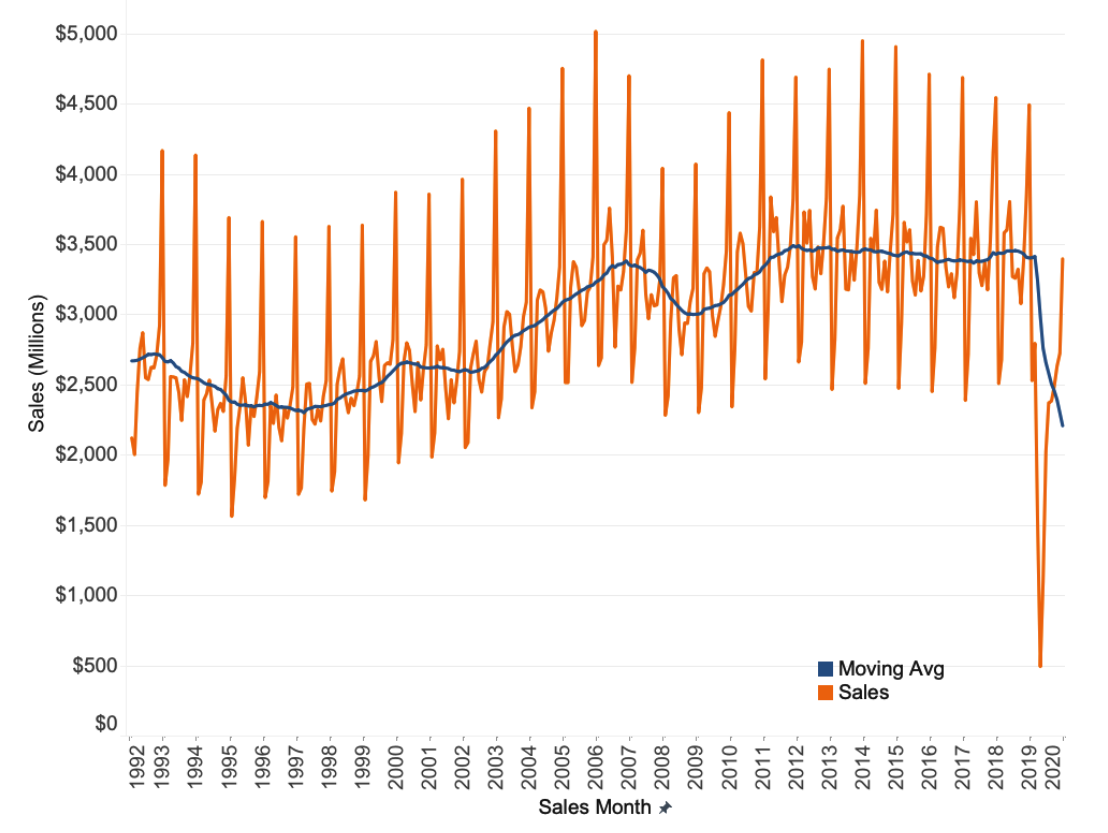

### Calculating Cumulative Values

In [66]:
-- Monthly sales and cumulative annual sales for women’s clothing stores
SELECT top 12
    sales_month,
    sales,
    sum(sales) over (PARTITION by year(sales_month) ORDER by sales_month) sales_ytd
from dbo.us_retail_sales
WHERE kind_of_business = 'Women''s clothing stores'
    AND YEAR(sales_month) >= 2016

(12 rows affected)

Total execution time: 00:00:00.022

sales_month,sales,sales_ytd
2016-01-01,2477,2477
2016-02-01,2939,5416
2016-03-01,3659,9075
2016-04-01,3519,12594
2016-05-01,3606,16200
2016-06-01,3240,19440
2016-07-01,3141,22581
2016-08-01,3388,25969
2016-09-01,3170,29139
2016-10-01,3274,32413


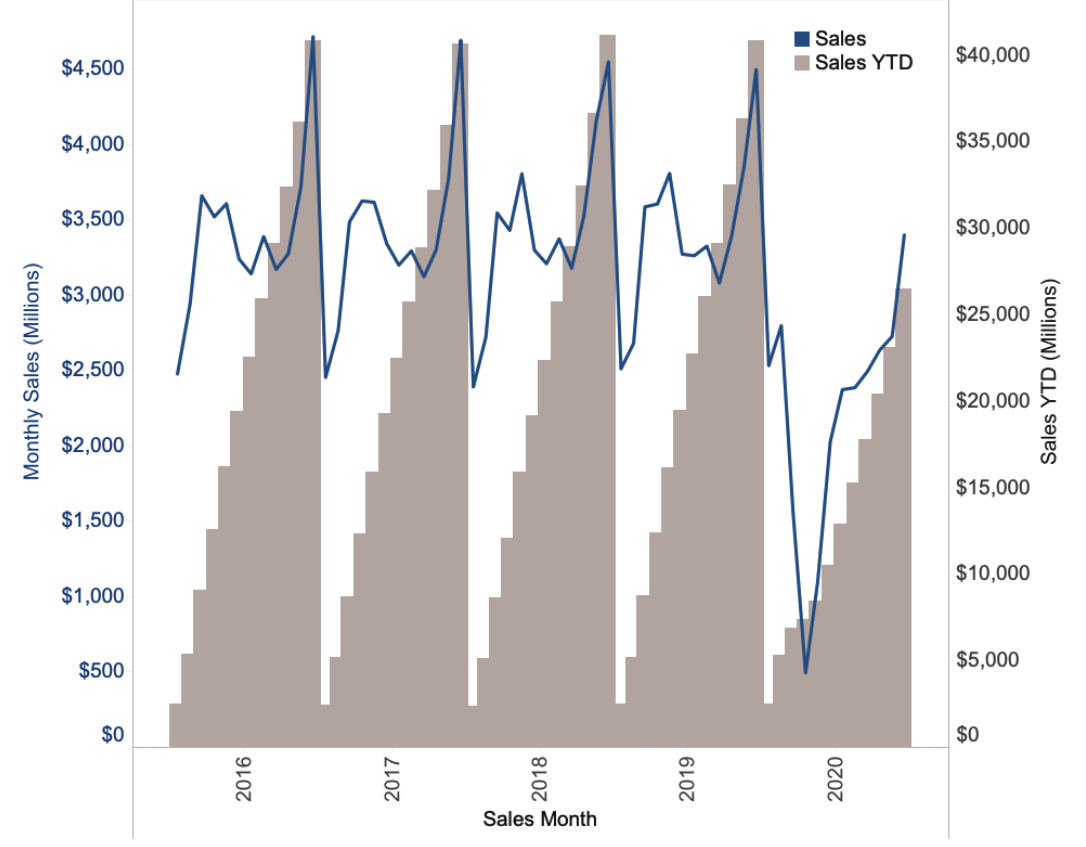

## Analyzing with Seasonality

Seasonality is any pattern that repeats over regular intervals. Unlike other noise in the data, seasonality can be predicted.

Below are examples of seasonality patterns in book store, grocery store, and jewelry store sales:

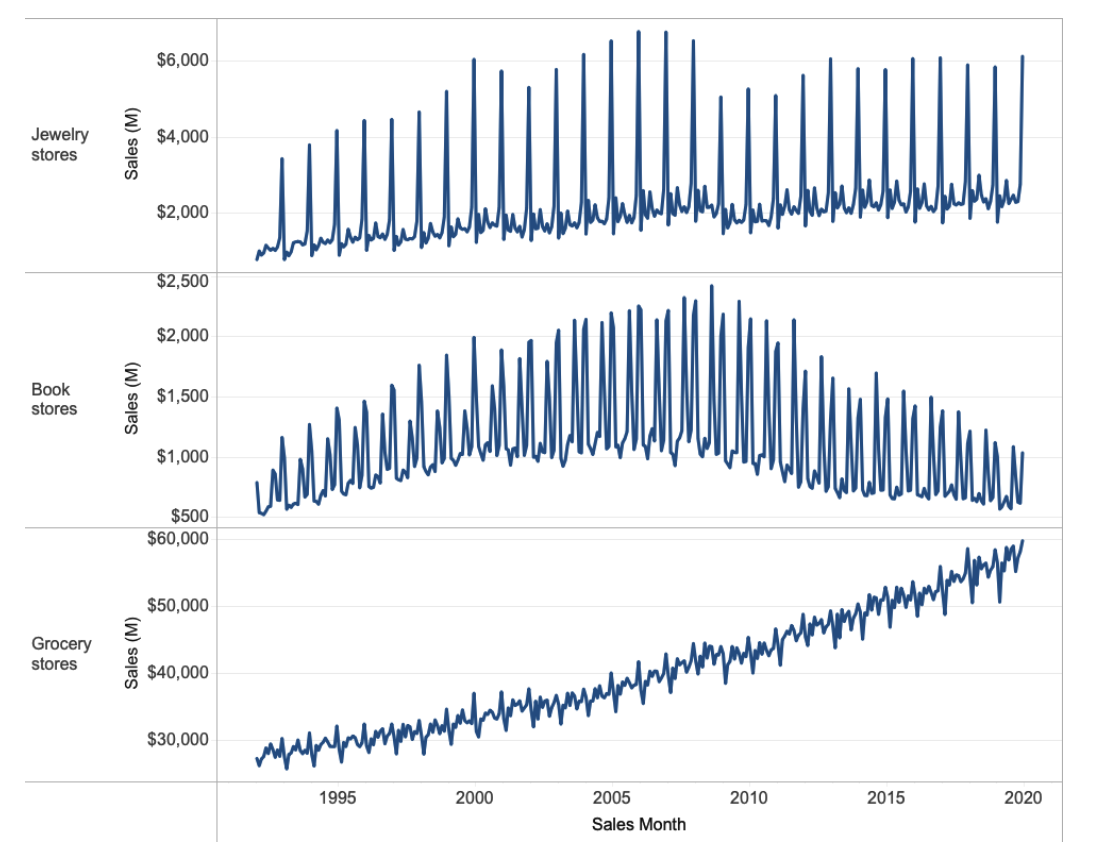

Ways to deal with seasonality:

- Smooth it out, either by aggregating the data to a less granular time period or by using rolling windows
- Benchmark against similar time periods and analyze the difference

### Period-over-Period Comparisons: year-over-year & month-over-month

In [1]:
-- % growth from previous year for US retail book store sales
SELECT top 10
    sales_year,
    sales,
    (cast(sales as dec(10,3)) / LAG(sales) over (order by sales_year) - 1)*100 as pct_from_last_year
from
(   
    select 
        year(sales_month) sales_year,
        sum(sales) as sales
    from dbo.us_retail_sales
    where kind_of_business = 'Book stores'
    GROUP BY YEAR(sales_month)
) year_tbl
ORDER BY 1

(10 rows affected)

Total execution time: 00:00:00.104

sales_year,sales,pct_from_last_year
1992,8327,NULL
1993,9108,9.37912813738441215323600
1994,10107,10.96837944664031620553300
1995,11196,10.77471059661620658949200
1996,11905,6.33261879242586638085000
1997,12742,7.03065938681226375472400
1998,13282,4.23795322555328833778000
1999,14172,6.70079807257943080861300
2000,14879,4.98871013265594129268900
2001,15098,1.47187310975199946232900


### Period-over-Period Comparisons: Same Month Versus Last Year

In [4]:
-- Book store sales, same month vs. last year absolute difference & % growth
SELECT top 10
    sales_month,
    sales,
    sales - prev_year_sales as abs_diff,
    (cast(sales as dec(10,3)) / prev_year_sales -1)*100 as pct_diff
from 
(SELECT
    sales_month,
    sales,
    lag(sales) over(partition by month(sales_month) order by sales_month) prev_year_sales
from dbo.us_retail_sales
where kind_of_business = 'Book stores'
) source_tbl
order BY MONTH(sales_month), YEAR(sales_month)

(10 rows affected)

Total execution time: 00:00:00.042

sales_month,sales,abs_diff,pct_diff
1992-01-01,790,NULL,NULL
1993-01-01,998,208,26.32911392405063291139200
1994-01-01,1053,55,5.51102204408817635270500
1995-01-01,1308,255,24.21652421652421652421600
1996-01-01,1373,65,4.96941896024464831804200
1997-01-01,1558,185,13.47414420975965040058200
1998-01-01,1463,-95,-6.09756097560975609756100
1999-01-01,1514,51,3.48598769651401230348500
2000-01-01,1505,-9,-0.59445178335535006605100
2001-01-01,1585,80,5.31561461794019933554800


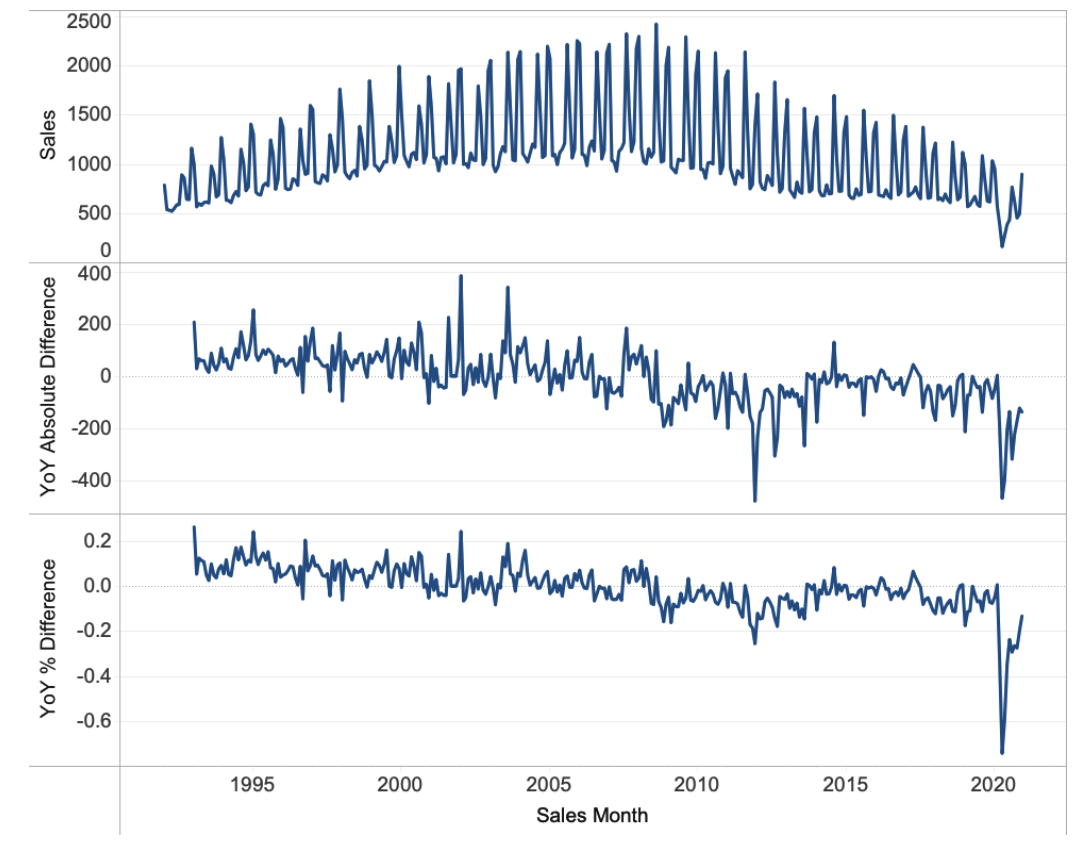

In [8]:
-- Book store sales for 1992–1994, aligned by month
select 
    month, [1992], [1993], [1994]
FROM
(
    select
        YEAR(sales_month) as year,
        sales,
        DATENAME(MONTH, sales_month) month,
        DATEPART(MONTH, sales_month) month_number
    from dbo.us_retail_sales
    WHERE kind_of_business = 'Book stores'
) src_tbl
PIVOT
(
    sum(sales)
    for year in ([1992], [1993], [1994])
) pivot_tbl
ORDER BY month_number

(12 rows affected)

Total execution time: 00:00:00.064

month,1992,1993,1994
January,790,998,1053
February,539,568,635
March,535,602,634
April,523,583,610
May,552,612,684
June,589,618,724
July,592,607,678
August,894,983,1154
September,861,903,1022
October,645,669,732


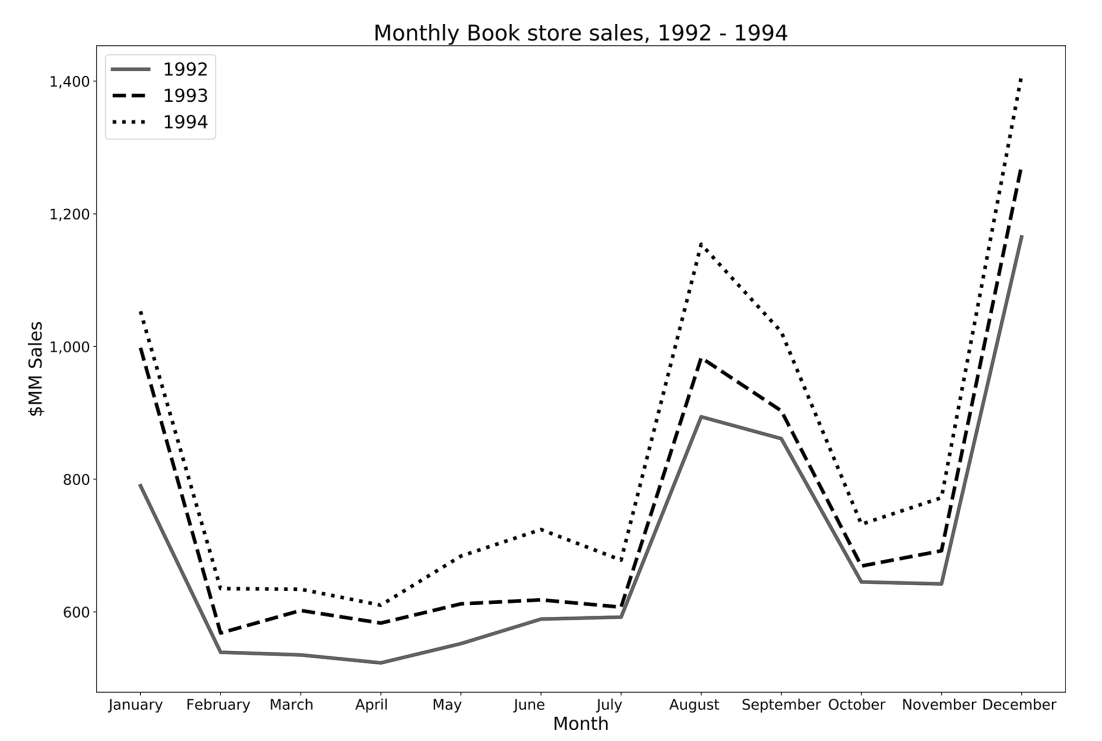

- Sales increased year to year in every month, though the increases were larger in some months than others.
- December sales are the highest monthly sales of the year.  
- The August-to-September sales decline is visible